In [1]:
# Import Dependencies

import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

from sqlalchemy import create_engine, inspect, Column, Integer, String
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base
Base=declarative_base()
from sqlalchemy.sql import func
from flask import Flask,jsonify

In [13]:
# Setting Up Database 
engine=create_engine('sqlite:///hawaii.sqlite')

# Create table in database
Base.metadata.create_all(engine)

# Start Session
session=Session(bind=engine)

In [26]:
# reflect an existing database into a new model
Base = automap_base()

In [27]:
# Use Base Class to reflect database tables
Base.prepare(engine, reflect=True)

In [28]:
# Classes mapped in database
Base.classes.keys()

['measurements', 'stations']

In [17]:
# Exploring the Database

inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [29]:
# Upload Measurement 
measurement_df=pd.read_csv('hawaii_measurement.csv')
measurement_df.to_sql(con=engine,name='measurements',if_exists='replace')

# Upload Stations 
stations_df=pd.read_csv('hawaii_stations.csv')
stations_df.to_sql(con=engine,name='stations',if_exists='replace')

In [30]:
# Inspect measurements table
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'],c["type"])

# Inspect stations table
columns=inspector.get_columns('stations')
for c in columns:
    print(c['name'],c["type"])

index BIGINT
id BIGINT
station TEXT
date TEXT
prcp FLOAT
tobs BIGINT
index BIGINT
id BIGINT
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [33]:
# Save references to each table
Measurement = Base.classes.measurements
Station = Base.classes.stations

session=Session(engine)

In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [36]:
last_year=dt.date(2017,8,23)-dt.timedelta(days=365)
print(last_year)

2016-08-23


In [37]:
# Perform a query to retrieve the data and precipitation scores
precipitation=session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date>last_year).\
    order_by(Measurement.date).all()

In [38]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_df=pd.DataFrame(precipitation)
precipitation_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


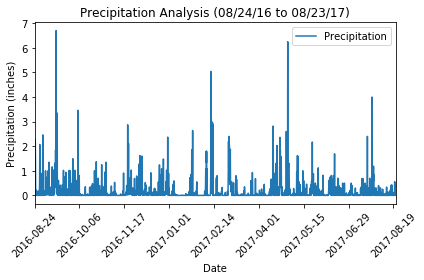

In [39]:
# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot('date','prcp')
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Analysis (08/24/16 to 08/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [41]:
# Station Analysis

# How many stations are available in this dataset?
locations=session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [42]:
# What are the most active stations? List the stations and the counts in descending order.

active_station=session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

most_active=active_station[0][0]
print("The most active station was",most_active,"with",active_station[0][1],"observations, which was the highest number of observations.")
print()
print("Here are all of the Stations and their number of observations in descending order:")
for station,count in active_station:
    print("Station",station,"had",count,"observations.")

The most active station was USC00519281 with 2772 observations, which was the highest number of observations.

Here are all of the Stations and their number of observations in descending order:
Station USC00519281 had 2772 observations.
Station USC00513117 had 2696 observations.
Station USC00519397 had 2685 observations.
Station USC00519523 had 2572 observations.
Station USC00516128 had 2484 observations.
Station USC00514830 had 1937 observations.
Station USC00511918 had 1932 observations.
Station USC00517948 had 683 observations.
Station USC00518838 had 342 observations.


In [43]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temperature=session.query(Measurement.station,Measurement.date,Measurement.tobs).\
    filter(Measurement.station==most_active).\
    filter(Measurement.date>last_year).\
    order_by(Measurement.date).all()

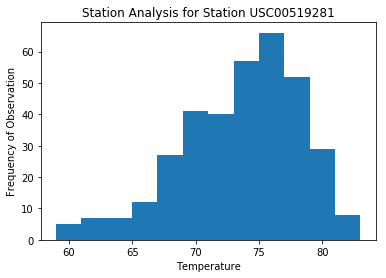

In [45]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Frequency of Observation")
plt.title("Station Analysis for Station "+ most_active)
plt.show()